In [85]:
from dateutil.parser import parse 
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [88]:
#Import data and dataframe
df = pd.read_csv("data_kmeans_v2.0.csv", parse_dates=['date_time'], index_col='date_time')

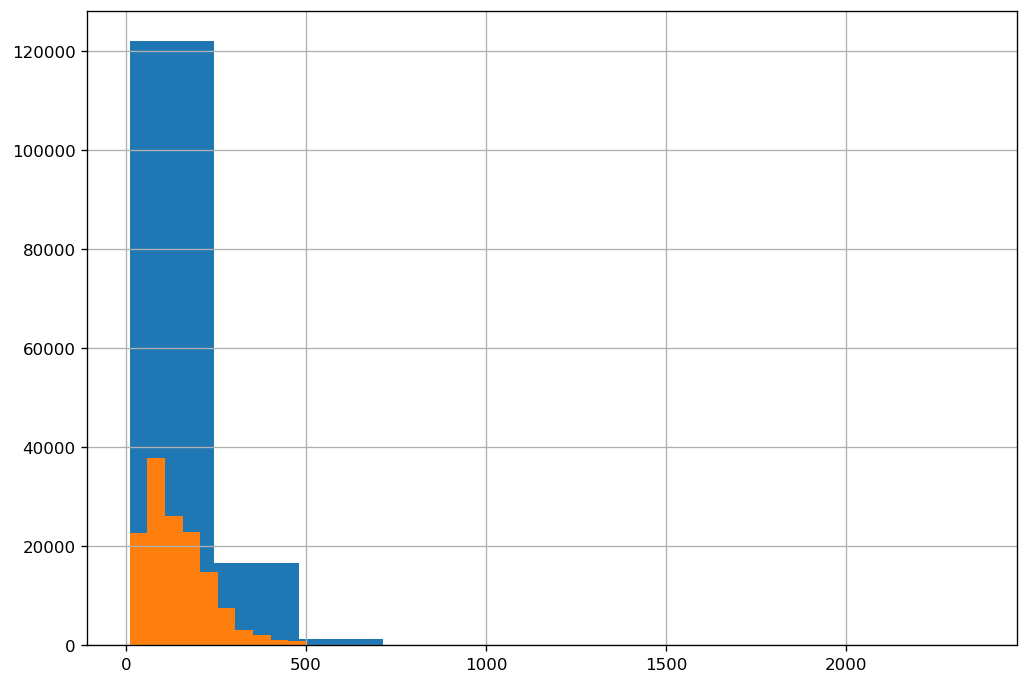

In [89]:
#Get rid of unreasonable prices

max(df["price_usd"])
min(df["price_usd"])

df.price_usd.hist()
df[df["price_usd"]<500].price_usd.hist()

df = df.loc[df["price_usd"]<500]

In [90]:
# Drop unnecessary columns
df_mod = df.drop(columns=["Unnamed: 0","srch_id", "visitor_hist_starrating", "visitor_hist_adr_usd", "prop_id", "position", "srch_length_of_stay", 
                          "srch_booking_window", "srch_adults_count", "srch_children_count", "srch_room_count", "srch_saturday_night_bool",
                          "random_bool", "comp1_rate", "comp1_inv", "comp1_rate_percent_diff", "comp2_rate", "comp2_inv", "comp2_rate_percent_diff", 
                          "comp3_rate", "comp3_inv", "comp3_rate_percent_diff", "comp4_rate", "comp4_inv", "comp4_rate_percent_diff", "comp5_rate", 
                          "comp5_inv", "comp5_rate_percent_diff", "comp6_rate", "comp6_inv", "comp6_rate_percent_diff", "comp7_rate", "comp7_inv", 
                          "comp7_rate_percent_diff", "comp8_rate", "comp8_inv", "comp8_rate_percent_diff", "booking_bool", 
                          "visitor_location_country_id", "prop_country_id", "srch_query_affinity_score", 
                          "srch_destination_id"])

df_mod.reset_index(inplace=True, drop=False)

#One-hot encode: site_id (34)
categorical_features = ["site_id"]
for col in categorical_features:
    dummies = pd.get_dummies(df_mod[col], prefix=col)
    df_mod = pd.concat([df_mod, dummies], axis=1)
    df_mod.drop(col, axis=1, inplace=True)

In [91]:
#Split into train-test
train = df_mod[df_mod.date_time < '2013-05-30']
test = df_mod[df_mod.date_time >= '2013-05-30']

#Drop date_time column to not affect kmeans clustering
train = train.drop('date_time', axis=1)
test = test.drop('date_time', axis=1)

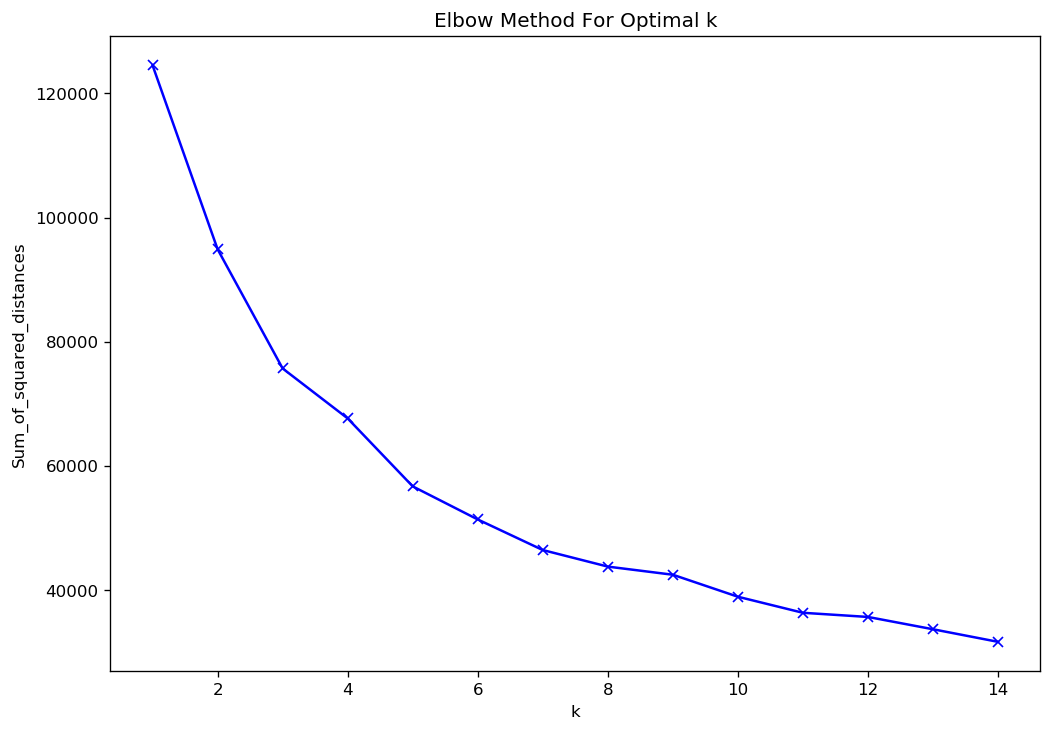

In [92]:
#Weigh features equally

mms = MinMaxScaler()
mms.fit(train)
df_s = mms.transform(train)

Sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_s)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

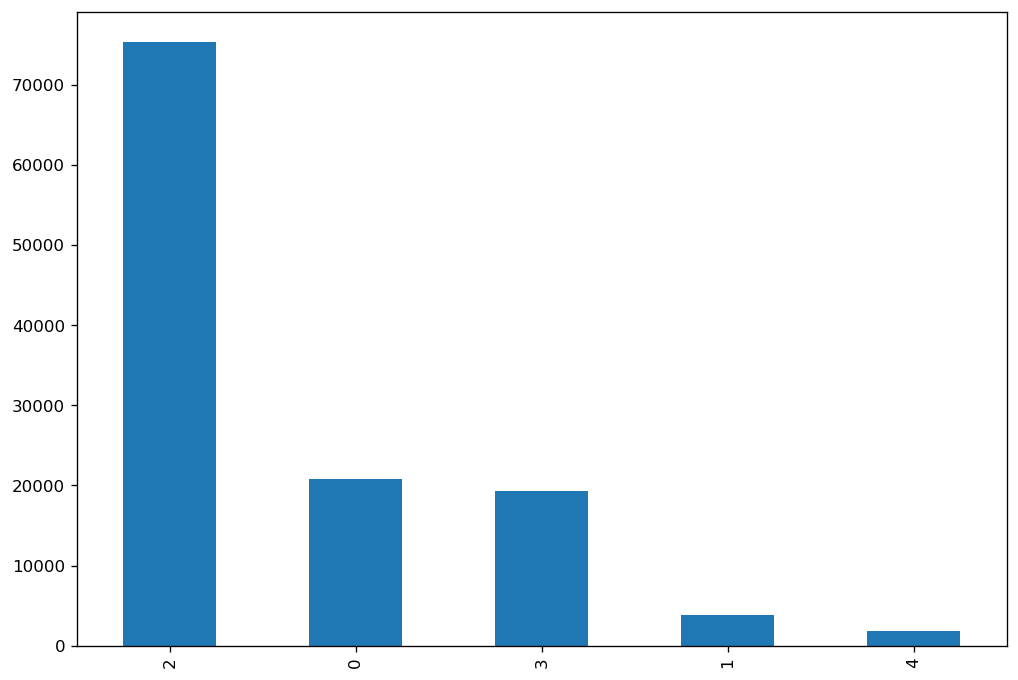

In [93]:
#Choosing K=6. K-means clustering to get hotel groups

kmeans = KMeans(n_clusters=5)
kmeans.fit(train)

#print(kmeans.cluster_centers_) #Centriods
#print(kmeans.labels_) #Hotel groups
train['Hotel_Group'] = kmeans.labels_
train_labels = kmeans.labels_
train['Hotel_Group'].value_counts().plot(kind='bar');

In [94]:
#Assign labels to test set

#Weigh features equally
mms = MinMaxScaler()
mms.fit(test)
df_s = mms.transform(test)

test_labels = kmeans.fit_predict(test)

In [95]:
#Keeping useful columns. Include "click_bool", "gross_bookings_usd", 
cols = ["site_id", "visitor_hist_starrating", "visitor_hist_adr_usd", "prop_id", "prop_starrating", "prop_review_score", 
        "prop_brand_bool", "prop_location_score1", "prop_log_historical_price", "position", "price_usd", "promotion_flag", 
        "srch_length_of_stay", "srch_booking_window", "srch_adults_count", "srch_children_count", "srch_room_count", 
        "srch_saturday_night_bool", "srch_query_affinity_score", "random_bool", "comp1_rate", "comp1_inv", "comp1_rate_percent_diff", 
        "comp2_rate", "comp2_inv", "comp2_rate_percent_diff", "comp3_rate", "comp3_inv", "comp3_rate_percent_diff", "comp4_rate", 
        "comp4_inv", "comp4_rate_percent_diff", "comp5_rate", "comp5_inv", "comp5_rate_percent_diff", "comp6_rate", "comp6_inv", 
        "comp6_rate_percent_diff", "comp7_rate", "comp7_inv", "comp7_rate_percent_diff", "comp8_rate", "comp8_inv", 
        "comp8_rate_percent_diff", "booking_bool", "visitor_location_country_id"]

#Reassign df_mod
df_mod = df.loc[:, cols]

#Remove hours
df_mod.index = df_mod.index.normalize()

#Train and Test set
train = df_mod[df_mod.index < '2013-05-30']
test = df_mod[df_mod.index >= '2013-05-30']

#Increment index by srch_booking_window to get booking start date
train.index = train.index.shift(train["srch_booking_window"].values, freq='D')
test.index = test.index.shift(test["srch_booking_window"].values, freq='D')

#Include Hotel Group from k-means
train["Hotel_Group"] = train_labels
test["Hotel_Group"] = test_labels

#Create number of row equals to length of stay, index as incremented date_time by a day each time
def per_day(df_orig, col):
    df = df_orig.copy()
    df.reset_index(inplace=True)
    list = []
    for idx, row in df.iterrows():
        dates = pd.date_range(start=row.date_time, periods=row.srch_length_of_stay)
        t = tuple(row)
        for date in dates:
            list.append((date,) + t)
            #return list
    df = pd.DataFrame(list, columns = ['stay_date', 'start_date'] + col + ["Hotel_Group"])
    df.set_index('stay_date', inplace=True)
    return df

#Gives one row per listing-night
train = per_day(train, cols)
test = per_day(test, cols)

/Users/michellechan/.julia/conda/3/lib/python3.7/site-packages/pandas/core/arrays/datetimelike.py:1151: PerformanceWarning: Adding/subtracting array of DateOffsets to DatetimeArray not vectorized
  PerformanceWarning,
/Users/michellechan/.julia/conda/3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/michellechan/.julia/conda/3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [96]:
#Only on train. To get seasonality multipliers. To be applied to train and test set
#Group by the date. use median price of that night as value
df_ts = train.groupby(by=train.index).median()["price_usd"]
df_ts = df_ts.to_frame()

df2_ts = test.groupby(by=test.index).median()["price_usd"]
df2_ts = df2_ts.to_frame()

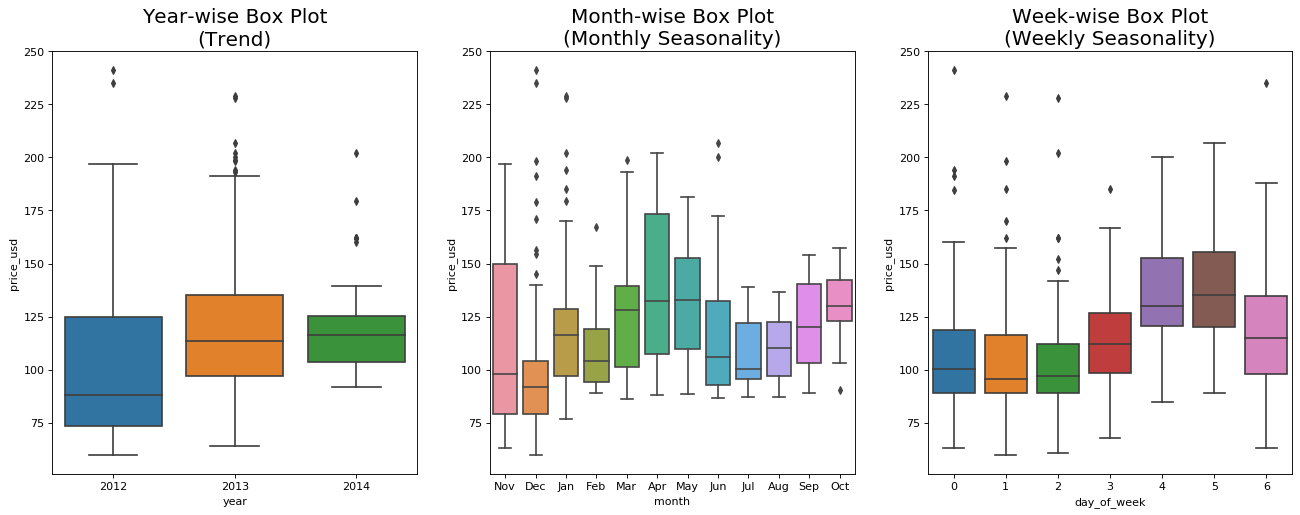

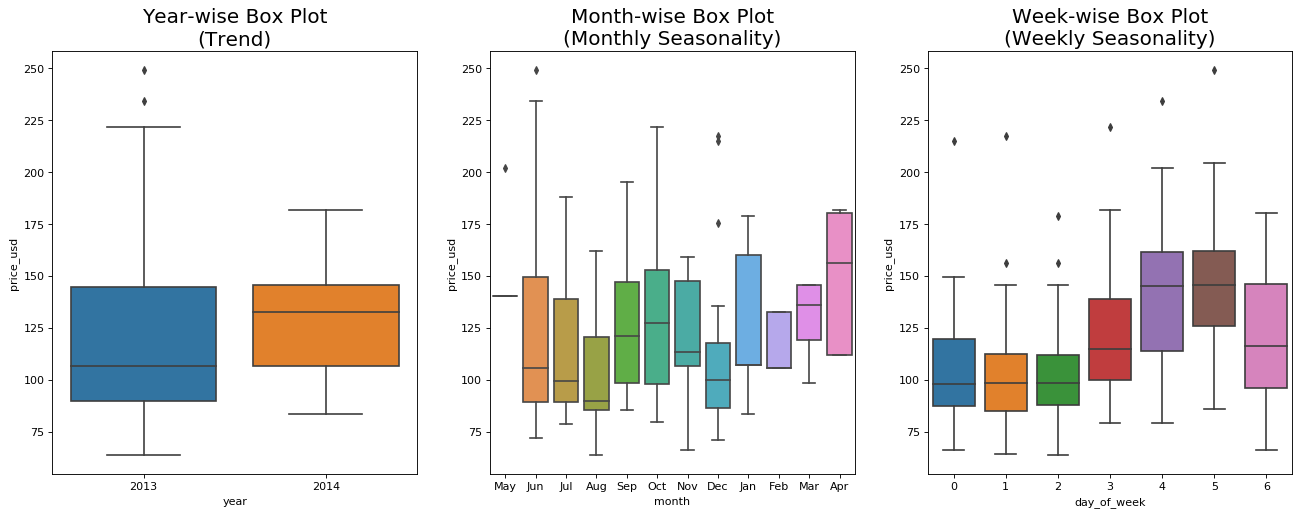

In [97]:
### Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution ###

def boxplot(df):
    # Prepare data
    df['year'] = [d.year for d in df.index]
    df['month'] = [d.strftime('%b') for d in df.index]
    df['day_of_week'] = [d.dayofweek for d in df.index]

    years = df['year'].unique()
    #df['log_price_usd'] = np.log(df['price_usd'])
  
    # Draw Plot
    fig, axes = plt.subplots(1, 3, figsize=(20,7), dpi= 80)
    
    sns.boxplot(x='year', y='price_usd', data=df, ax=axes[0])
    sns.boxplot(x='month', y='price_usd', data=df, ax=axes[1])
    sns.boxplot(x='day_of_week', y='price_usd', data=df, ax=axes[2])
  
    # Set Title
    axes[0].set_title('Year-wise Box Plot\n(Trend)', fontsize=18); 
    axes[1].set_title('Month-wise Box Plot\n(Monthly Seasonality)', fontsize=18)
    axes[2].set_title('Week-wise Box Plot\n(Weekly Seasonality)', fontsize=18)

    plt.show()

boxplot(df_ts)
boxplot(df2_ts)
#df_mod.to_csv("data_v2.csv")

In [98]:
###Multipliers gotten from train set only ###
#Month multipliers
month = df_ts.groupby('month').mean()['price_usd']
month_mult = month/month.loc['Jan']
month_mult = month_mult.to_frame()
month_mult.rename(columns={'price_usd':'monthly_mult'}, inplace=True)

In [110]:
temp = month_mult.reset_index().sort_values(by='month')
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
temp['month'] = pd.Categorical(temp['month'], categories=months, ordered=True)
#temp.sort_values(by='month').drop(columns=['month']).to_csv("month_multv1.csv")

In [99]:
#Day_of_week multipliers
temp = df_ts.reset_index()
temp['day_of_week'] = temp['stay_date'].dt.dayofweek
temp = temp.set_index('stay_date')

#Week multipliers
week = temp.groupby('day_of_week').mean()['price_usd']
week_mult = week/week.loc[0]
week_mult = week_mult.to_frame()
week_mult.rename(columns={'price_usd':'weekly_mult'}, inplace=True)

In [112]:
#week_mult.to_csv("week_multv1.csv")

In [368]:
#Deseasonalize at a weekly and monthly level
temp = df_ts.merge(week_mult, on='day_of_week', how='left')
temp = temp.merge(month_mult, on='month', how='left')
temp.index = df_ts.index
temp.drop('price_usd', axis=1, inplace=True)
temp = train.merge(temp, on='stay_date', how='left')

In [369]:
temp['Intrinsic_value'] = temp['price_usd'] / (temp['weekly_mult'] * temp['monthly_mult'])
train = temp

In [376]:
#Get intrinsic value of test set points using kNN
from sklearn.neighbors import KNeighborsRegressor

def getintrinsic(train, test):
    test['Intrinsic_value'] = 0
    predict_col = ['prop_starrating', 'prop_review_score', 'prop_brand_bool', 'prop_location_score1', 
             'prop_log_historical_price', 'price_usd', 'srch_length_of_stay', 'srch_adults_count', 
             'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool']
    #Split into each cluster, then perform kNN
    clusters = np.unique(train['Hotel_Group'])
    for c in clusters:
        temp = train.loc[train['Hotel_Group'] == c]
        X_train = temp[predict_col]
        y_train = temp['Intrinsic_value']
        
        temp2 = test.loc[test['Hotel_Group'] == c]
        X_test = temp2[predict_col]
        
        neigh = KNeighborsRegressor(n_neighbors=5, weights='uniform')
        neigh.fit(X_train, y_train)
        test.loc[test['Hotel_Group'] == c, 'Intrinsic_value'] = neigh.predict(X_test)
    return test

In [379]:
test = getintrinsic(train,test)
temp = df2_ts.merge(week_mult, on='day_of_week', how='left')
temp = temp.merge(month_mult, on='month', how='left')
temp.index = df2_ts.index
temp.drop('price_usd', axis=1, inplace=True)
temp = test.merge(temp, on='stay_date', how='left')
test = temp

,year,month,day-of-week,weekly_mult,monthly_mult
stay_date,,,,,
2013-05-31,2013,May,4,1.252598,1.085939
2013-06-01,2013,Jun,5,1.296770,0.966557
2013-06-02,2013,Jun,6,1.108617,0.966557
2013-06-03,2013,Jun,0,1.000000,0.966557
2013-06-04,2013,Jun,1,0.970713,0.966557
...,...,...,...,...,...
2014-05-18,2014,May,6,1.108617,1.085939
2014-05-19,2014,May,0,1.000000,1.085939
2014-06-02,2014,Jun,0,1.000000,0.966557


In [389]:
#Check if data looks fine
#train.describe()
#test.describe()
#train.to_csv("trainv1.csv")
#test.to_csv("testv1.csv")

In [18]:
train = pd.read_csv("trainv1.csv", parse_dates=['stay_date'], index_col='stay_date')
test = pd.read_csv("testv1.csv", parse_dates=['stay_date'], index_col='stay_date')

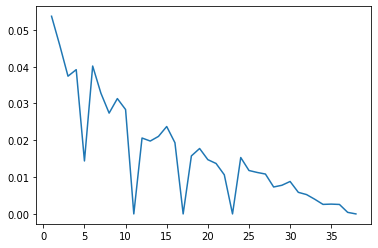

In [19]:
pos = np.unique(train['position']) #38 different positions
bp_by_rank = train.groupby('position').mean()['booking_bool']
plt.plot(bp_by_rank) #Effect of ranking on booking probability
bp_by_rank = bp_by_rank.reset_index()
bp_by_rank = bp_by_rank.rename(columns={"position":"x", "booking_bool":"y"})
x = np.array(bp_by_rank['x'])
y = np.array(bp_by_rank['y'])

In [20]:
#Remove outliers #5, 11, 17, 23
bp_by_rank = bp_by_rank.drop([4,10,16,22])
x = np.array(bp_by_rank['x'])
y = np.array(bp_by_rank['y'])

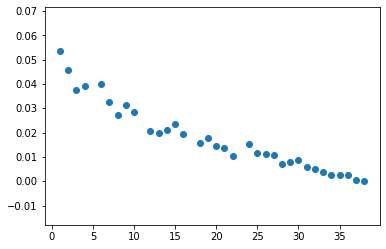

In [21]:
plt.scatter(x,y)
#Remove outliers

In [22]:
def poly(x,a,b,c):
    return a*(x**2) + b*x + c

def exponential(x,a,b,c):
    return a*np.exp(x*b) + c 

def spline(x,a,b,c,d):
    return a*(x**3) + b*(x**2) + c*x + d

In [25]:
popt_poly_true, _ = scipy.optimize.curve_fit(poly,x,y)
popt_exp_true, _ = scipy.optimize.curve_fit(exponential,x,y)
popt_spline_true, _ = scipy.optimize.curve_fit(spline,x,y)

popt_poly_true
#popt_exp_true

array([ 2.57000246e-05, -2.18283279e-03,  4.82663673e-02])

0.9601971996750573

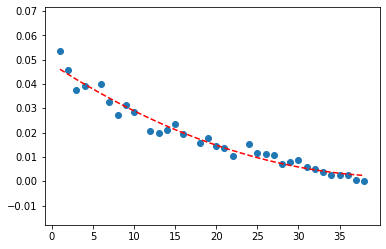

In [24]:
#For polynomial fit
fitted_value_true = poly(x,popt_poly_true[0],popt_poly_true[1],popt_poly_true[2])
plt.scatter(x,y)
plt.plot(x,fitted_value_true,"r--")

residuals = y - poly(x,popt_poly_true[0],popt_poly_true[1],popt_poly_true[2])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r2 = 1 - (ss_res / ss_tot)
r2

-30404628.49467014

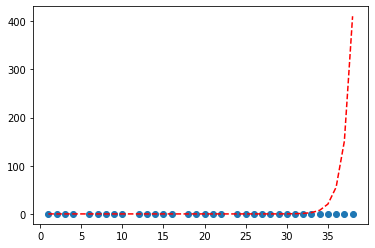

In [9]:
#For exponential fit

fitted_value_true = exponential(x,popt_exp_true[0],popt_exp_true[1],popt_exp_true[2])
plt.scatter(x,y)
plt.plot(x,fitted_value_true,"r--")

residuals = y - exponential(x,popt_exp_true[0],popt_exp_true[1],popt_exp_true[2])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r2 = 1 - (ss_res / ss_tot)
r2

0.9740592346366654

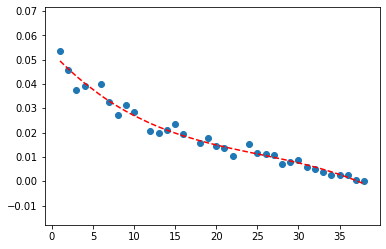

In [10]:
#For spline fit
fitted_value_true = spline(x,popt_spline_true[0],popt_spline_true[1],popt_spline_true[2], popt_spline_true[3])
plt.scatter(x,y)
plt.plot(x,fitted_value_true,"r--")

residuals = y - fitted_value_true
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r2 = 1 - (ss_res / ss_tot)
r2

In [61]:
#Estimate average position corresponding to Intrinsic Value for each cluster
def avg_pos(df):
    avg_pos = np.zeros(5)
    for i in range(0,5):
        temp = df[df['Hotel_Group']==i]
        counts_by_pos = np.array(temp.position.value_counts().sort_index())
        total_pos_sum = np.dot(counts_by_pos,np.array([i for i in range(1,39,1)]))
        avg_pos[i] = total_pos_sum/len(temp)
    return avg_pos
#Average position

avg_pos(train) #We see that average weighted position is similar for all clusters at 18. Hence, rank multipliers are 
#generalizable across clusters

array([18.33086146, 18.45411204, 18.13053942, 18.22581439, 17.8658199 ])

In [82]:
pos = np.array([i for i in range(1,39)])
a = popt_poly_true[0]; b = popt_poly_true[1]; c = popt_poly_true[2]
bp = np.array(poly(pos,a,b,c))
rank_mult = bp/bp[17]
rank_mult = pd.DataFrame(data = rank_mult, index= range(1,39), columns = ['rank_mult'])
#rank_mult.to_csv("rank_multv1.csv")

,rank_mult
1,2.664937
2,2.543234
3,2.424501
4,2.308739
5,2.195948
6,2.086128
7,1.979278
8,1.875399
9,1.774491
10,1.676554


In [ ]:
### Rejected Code ###

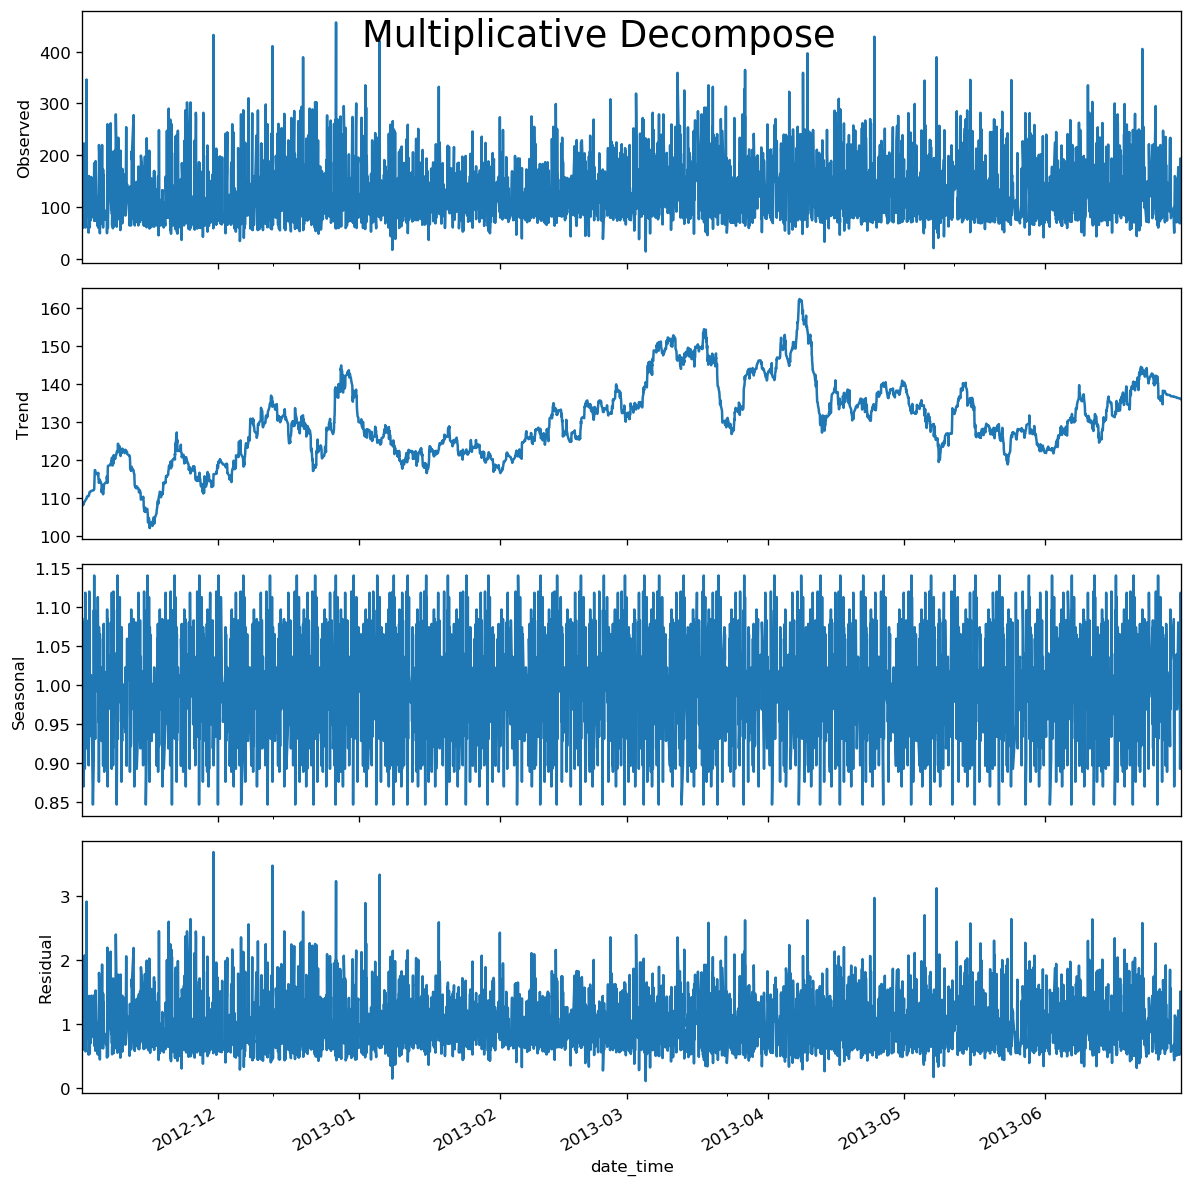

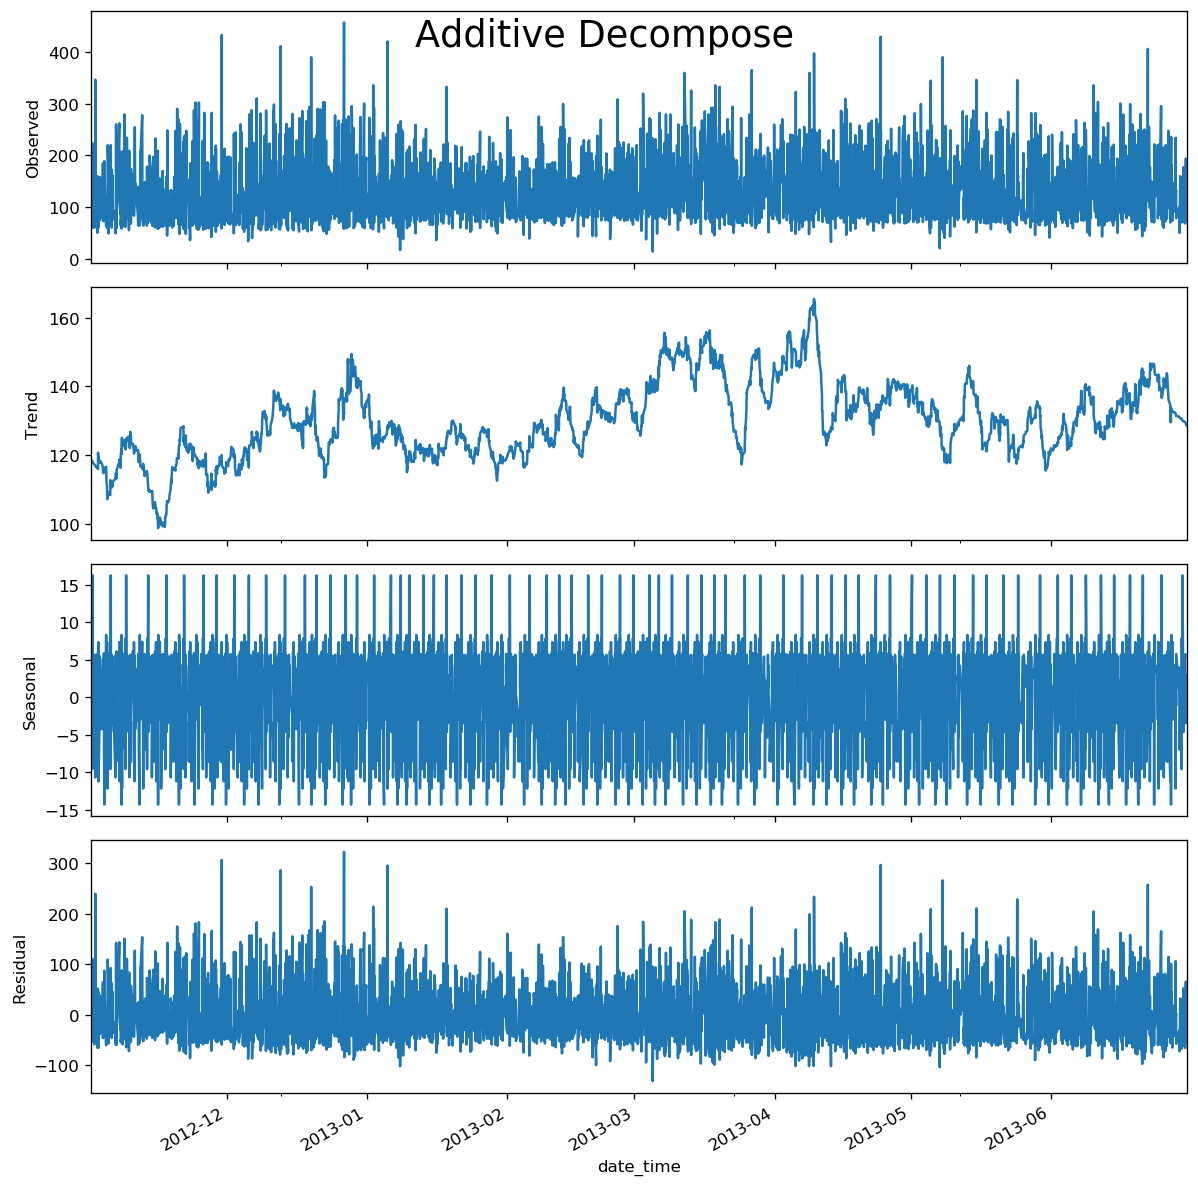

In [110]:
from dateutil.parser import parse


# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_ts['price_usd'], model='multiplicative', extrapolate_trend='freq', freq=100)

# Additive Decomposition
result_add = seasonal_decompose(df_ts['price_usd'], model='additive', extrapolate_trend='freq', freq=70)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [ ]:
###Using multiplicative series. Results seem better than additive series ###
#convert a non-stationary multiplicative series to stationary
def s_t_p(result, mul, data):
    df = pd.concat([result.seasonal, result.trend, result.resid, result.observed], axis=1)
    df.columns = ['seas', 'trend', 'resid', 'actual_values']
    if mul == 1:
        df['seasonality_trend_product'] = df['seas'] * df['trend']
        #join to original dataset
        df = pd.merge(data, df, how='left', on='stay_date')
        df["dt_ds_price_usd"] = df["price_usd"]/df["seasonality_trend_product"]
    else:
        df['seasonality_trend_sum'] = df['seas'] + df['trend']
        #join to original dataset
        df = pd.merge(data, df, how='left', on='stay_date')
        df["dt_ds_price_usd"] = df["price_usd"]-df["seasonality_trend_sum"]
    return df

df_mul = s_t_p(result_mul, 1, df)
df_add = s_t_p(result_add, 0, df)